## UCL COMP0029 Individual Project for Year 3 BSc
### Robust Robotic Grasping Utilising Touch Sensing - Proposed Learning Framework Notebook
This notebook contains the essential code for training and testing a simplified learning framework for the proposed method - a simple multilayer perceptron to predict grasp outcomes.

### 1. Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import gc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

import seaborn as sns

Set device for `PyTorch` training

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

PyTorch configs

In [3]:
gc.collect()
torch.cuda.empty_cache()
torch.set_num_threads(2)

In [4]:
np.errstate(invalid='ignore', divide='ignore')

### 2. Load datasets from saved .npy files

To collect data for this experiment, you can run the "Collect Sensory Data" button in the Pybullet simulation. This generates a predefined number of Gaussian grasps randomly generated from a base hand pose. Each individual grasp is considered as an individual experiment, and the data collected from this experiment is split into four, each stored in its own dataset.

For all object models used in this experiment, each object has 4 datasets which include:
- `depth_ds.npy` which stores the depth tactile data from the mounted DIGIT sensors
- `color_ds.npy` which stores the colored (RGB) version of the depth tactile data from the mounted DIGIT sensors
- `poses_ds.npy` which stores the randomly-generated 6d hand poses from the simulation
- `outcomes_ds.npy` which stores the outcomes of each random pose

In this notebook, we will use the following dataset combinations:
- `tactile` only (depth + colour)
- `visual` without geometric features
- `visual` with geometric features
- `multi-modal` consisting of `tactile` and `visual`
- `complete` consisting of `tactile` and `visual` with geometric features

In [5]:
root = "../datasets/"

In [6]:
object_names = ["block1", "block2", "block3", "cylinder1", "cylinder2", "cylinder3", "mustard_bottle1", "mustard_bottle2", "mustard_bottle3"]

Load `.npy` datasets via `np.load()`

In [7]:
depth_data = np.empty((0, 2, 160, 120))
color_data = np.empty((0, 2, 160, 120, 3))
poses_data = np.empty((0, 6))
grasp_outcomes_data = np.empty((0,))

for object_name in object_names:
    # Construct the relative paths of each dataset and load them into the notebook
    depth_data_temp = np.load(root + object_name + "_ds/depth_ds.npy", mmap_mode='r')
    colour_data_temp = np.load(root + object_name + "_ds/color_ds.npy", mmap_mode='r')
    poses_data_temp = np.load(root + object_name + "_ds/poses_ds.npy", mmap_mode='r')
    grasp_labels_temp = np.load(root + object_name + "_ds/grasp_outcomes.npy", mmap_mode='r')

    depth_data = np.append(depth_data, depth_data_temp, axis=0)
    color_data = np.append(color_data, colour_data_temp, axis=0)
    poses_data = np.append(poses_data, poses_data_temp, axis=0)
    grasp_outcomes_data = np.append(grasp_outcomes_data, grasp_labels_temp, axis=0)

In [8]:
del depth_data_temp, colour_data_temp, poses_data_temp, grasp_labels_temp
torch.cuda.empty_cache()

These datasets should all be in the form of $(N\times...)$ where $N$ is the number of examples:

In [9]:
print(f"Shape of depth_data: {depth_data.shape}")
print(f"Shape of color_data: {color_data.shape}")
print(f"Shape of poses_data: {poses_data.shape}")
print(f"Shape of grasp_outcomes_data: {grasp_outcomes_data.shape}")

Shape of depth_data: (1440, 2, 160, 120)
Shape of color_data: (1440, 2, 160, 120, 3)
Shape of poses_data: (1440, 6)
Shape of grasp_outcomes_data: (1440,)


Additionally, we confirm the number of successful and unsuccessful grasps recorded. This helps us in the next section to determine how many examples we should include for each class in order to produce a balanced dataset.

In [10]:
print(f"# of sucessesful grasps: {(grasp_outcomes_data == 1).sum()}")
print(f"# of unsuccessful grasps: {(grasp_outcomes_data == 0).sum()}")

# of sucessesful grasps: 720
# of unsuccessful grasps: 720


### 3. Preprocessing

In this section, we create the required datasets specified from section 2, and normalise the datasets.

#### 3.1 Normalization

In [11]:
def normalize(arr):
    # Normalize & standardize each column
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    
    arr = (arr - mean) / std
    arr = np.nan_to_num(arr, 0)
    arr[np.isinf(arr)] = 0
    return arr

Depth and colour data consists of pairs of tactile sensory readings. Thus, we concatenate each pair together into single images

In [12]:
depth_data = np.concatenate((depth_data[:, 0], depth_data[:, 1]), axis=2)
color_data = np.concatenate((color_data[:, 0], color_data[:, 1]), axis=2)

In [13]:
depth_data = torch.from_numpy(normalize(depth_data))
color_data = torch.from_numpy(normalize(color_data))
visual_data = torch.from_numpy(np.nan_to_num(normalize(poses_data)))

In [14]:
print(f"Shape of depth_ds: {depth_data.shape}")
print(f"Shape of colour_ds: {color_data.shape}")
print(f"Shape of visual_ds: {visual_data.shape}")

Shape of depth_ds: torch.Size([1440, 160, 240])
Shape of colour_ds: torch.Size([1440, 160, 240, 3])
Shape of visual_ds: torch.Size([1440, 6])


Create the tactile dataset

In [15]:
tactile_data = torch.cat([depth_data.unsqueeze(-1), color_data], dim=-1)
tactile_data = torch.nan_to_num(tactile_data)

In [16]:
print(f"Shape of tactile_ds: {tactile_data.shape}")

Shape of tactile_ds: torch.Size([1440, 160, 240, 4])


In [17]:
del depth_data, color_data, poses_data
torch.cuda.empty_cache()

#### Dimensionality reduction

In [18]:
# A simple convolutional neural network that extracts features from an input tensor
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=3)


    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = self.pool(x)

        return x

In [19]:
# Preprocess data using CNN feature extraction
cnn = FeatureExtractorCNN()
cnn_tactile = torch.cat([cnn(img.float().permute(2,0,1)).unsqueeze(0) for img in tactile_data])
cnn_tactile = cnn_tactile.reshape(cnn_tactile.shape[0], -1)
cnn_tactile.shape

torch.Size([1440, 512])

In [20]:
del tactile_data

### 4. Testing different data representations

In our MLP model, there are two fully connected (dense) layers, each with an activation function (ReLU for the first layer and no activation for the second layer). The input size, hidden size, and output size are parameters that need to be specified when creating an instance of the MLP.

In [21]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.parameters())

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
        
    def train_mlp(self, epochs, X_train, y_train):
        self.losses = []
        for i in range(epochs):
            inputs = torch.from_numpy(X_train).float()
            labels = torch.from_numpy(y_train).float().view(-1, 1)

            # Zero the gradients
            self.optimizer.zero_grad()

            # Forward pass
            preds = self(inputs)
            loss = self.criterion(preds, labels)
            self.losses.append(loss.item())

            # Backward pass and optimization
            loss.backward()
            self.optimizer.step()

            if i % 10 == 0:
                torch.cuda.empty_cache()

    def eval_mlp(self, X_test, y_test, verbose=False):
        # Evaluate the performance of the model on the testing set
        with torch.no_grad():
            inputs = torch.from_numpy(X_test).float()
            labels = torch.from_numpy(y_test).float().view(-1, 1)

            # Forward pass
            final_preds = self(inputs)
            predicted = (final_preds > 0).float()
            
            # Confusion matrix
            if verbose:
                cm = confusion_matrix(y_test, predicted)
                sns.heatmap(cm, linewidths=1, annot=True, fmt='g')

            # Accuracy
            accuracy = (predicted == labels).float().mean()
            return round(accuracy.item() * 100, 2)
    
    def plot_losses(self):
        plt.plot(self.losses)
        plt.xlabel('Epochs')
        plt.ylabel('Training Loss')
        plt.show()

#### 4a. Testing datatset combinations (CNN dimensionality-reduced) without geometric features

In [22]:
def train_mlp_multitrial(dataset, trials_count: int = 5):
    accuracies = np.empty((trials_count, ))

    for i in range(trials_count):
        X_train, X_test, y_train, y_test = train_test_split(dataset.detach().numpy(), grasp_outcomes_data, test_size=0.2)
        mlp = MLP(input_size=X_train.shape[1], hidden_size=64, output_size=1)
        mlp.train_mlp(epochs=500, X_train=X_train, y_train=y_train)
        accuracy = mlp.eval_mlp(X_test=X_test, y_test=y_test)
        accuracies[i] = accuracy

        torch.cuda.empty_cache()
    
    accuracy_mean = np.mean(accuracies)
    accuracy_std = np.std(accuracies)
    return accuracies, accuracy_mean, accuracy_std

Train Tactile-only dataset + CNN

In [23]:
accuracies, accuracy_mean, accuracy_std = train_mlp_multitrial(cnn_tactile, trials_count=5)

In [24]:
print(f"Tactile-only MLP accuracies: {accuracies}\n Mean: {accuracy_mean:.2f} | Std: {accuracy_std:.2f}")

Tactile-only MLP accuracies: [73.61 71.88 67.71 70.83 73.61]
 Mean: 71.53 | Std: 2.18


In [25]:
torch.cuda.empty_cache()

Train Visual-only dataset + CNN

In [26]:
accuracies, accuracy_mean, accuracy_std = train_mlp_multitrial(visual_data, trials_count=5)

In [27]:
print(f"Visual-only MLP accuracies: {accuracies}\n Mean: {accuracy_mean:.2f} | Std: {accuracy_std:.2f}")

Visual-only MLP accuracies: [58.33 61.81 60.07 63.19 57.29]
 Mean: 60.14 | Std: 2.17


In [28]:
torch.cuda.empty_cache()

Train Multi-modal dataset (tactile + visual) + CNN

In [29]:
# We simply combine the cnn-processed tactile data (from Section 5.3.1) with the visual data
cnn_complete = torch.cat([cnn_tactile.reshape(cnn_tactile.shape[0], -1), visual_data], dim=1)

In [30]:
accuracies, accuracy_mean, accuracy_std = train_mlp_multitrial(cnn_complete, trials_count=5)

In [31]:
print(f"Multi-modal MLP accuracies: {accuracies}\n Mean: {accuracy_mean:.2f} | Std: {accuracy_std:.2f}")

Multi-modal MLP accuracies: [75.35 73.26 69.1  72.92 72.92]
 Mean: 72.71 | Std: 2.02


In [32]:
del cnn_complete
torch.cuda.empty_cache()

### 5. Determining impact of geometric features of objects on MLP accuracy
This section aims to determine the capability of the selected object features (principal components) in identifying primitive object classes.

In [33]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler


np.set_printoptions(precision=2, formatter={'float_kind': "{:.3f}".format})

#### 5a. Clustering for object features using PCA

Loading object features

In [34]:
### Object features
block_features = np.array([
    [0.025, 0.05, 0.05, 0., 0., 0., 0., 0., 0.],
    [0.03, 0.025, 0.045, 0., 0., 0., 0., 0., 0.],
    [0.05, 0.025, 0.04, 0., 0., 0., 0., 0., 0.],
    # [8251.86033209, 380793.32718545, 8251.86033209, 380793.32718545, 7340.53467028, 323264.58605476],
    # [17358.04440407, 46879.37104777, 25111.58320378, 60764.07706612, 39914.37898048, 46661.69902607],
    # [8941.59628842, 178701.35111026, 6592.38039092, 211671.05821614, 37993.39435821, 115665.30894101]
])

cylinder_features = np.array([
    [0.04, 0.04, 0.05, 950.21606561, 14540.28434464, 950.21606561, 14540.28434464, 950.21606561, 14540.28434464],
    [0.045, 0.045, 0.035, 750.78800246, 11488.6197291, 750.78800246, 11488.6197291, 750.78800246, 11488.6197291],
    [0.034, 0.034, 0.045, 1315.17794549, 20124.96103064, 1315.17794549, 20124.96103064, 1315.17794549, 20124.96103064]
    # [1863.04007165, 4445.05882512, 3444.58243043, 116245.56798876, 3444.58243043, 116245.56798876],
    # [25350.56805999, 90897.43464835, 25130.96875937, 90779.57624788, 40959.86108762, 65384.53394801],
    # [8129.18609508, 13671.31408669,  5531.60803704, 12058.88586025, 7112.6668489 , 40254.7491457]
])

bottle_features = np.array([
    [0.06, 0.04, 0.04, 43195.64459266, 114198.0441697 , 45229.93706864, 135651.61794731, 75768.06626518,  83802.00991944],
    [0.04, 0.06, 0.06, 68993.34322089, 220902.86884084, 75354.47923164, 239160.99530455, 109695.41304924, 147938.06047763],
    [0.04, 0.06, 0.04, 61744.75459905, 168925.8805044 , 68143.84372052, 148775.07141178, 73102.67367022, 102953.40831915]
    # [58743.54544376, 155331.31241432, 64091.03332161, 156228.08639407, 78705.15565092, 107053.40095796],
    # [50165.53259195, 64214.77371792, 38058.77302717, 82455.45932214, 53901.08662624, 65393.21442221],
    # [61150.93285712, 137872.41617152,  59952.3159986 , 132257.80102161, 83815.39602093, 134698.94798265]
])

object_names = {0: 'cylinder', 1: 'block', 2: 'bottle'}

Feature transformation - concatenating features together

In [35]:
object_features = (block_features, cylinder_features, bottle_features)
features = np.concatenate(object_features)
labels = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])

Standardize the data

In [36]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

PCA

In [37]:
def pca(data, k, verbose=True):
    pca = PCA(n_components=k)
    pca.fit(data)

    if verbose:
        print(f"Variance captured: {sum(pca.explained_variance_ratio_)*100:.2f}%")
    return pca.transform(data)

Determine the number of components to use

In [38]:
for i in range(1, 5):
    pca_res = pca(features, k=i)

Variance captured: 74.58%
Variance captured: 91.43%
Variance captured: 97.34%
Variance captured: 99.65%


Variance captured: 97.34%


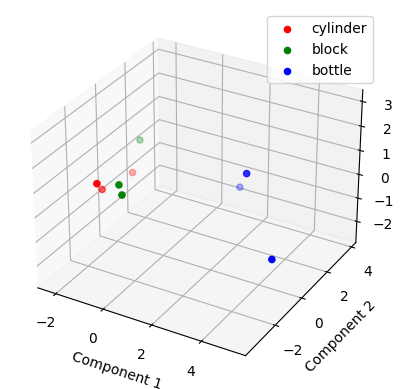

In [39]:
### Plot 3-feature PCA results
pca3d = pca(features, k=3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
for i, c in zip(np.unique(labels), colors):
    ax.scatter(pca3d[labels == i, 0], pca3d[labels == i, 1], pca3d[labels == i, 2], c=c, label=object_names[i])

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_aspect('equal', 'box')
ax.legend()
plt.show()

#### 5b. MLP: Dataset combination 4: Visual (EE pose and geometric features) + CNN

In [40]:
blocks = np.repeat(np.concatenate(object_features), 160, axis=0)

visual_data = np.concatenate((visual_data, blocks), axis=1)
visual_data = torch.from_numpy(np.nan_to_num(normalize(visual_data)))
visual_data.shape

torch.Size([1440, 15])

In [41]:
del object_features, blocks

Train Visual-only (EE pose + geometric features) + CNN

In [42]:
accuracies, accuracy_mean, accuracy_std = train_mlp_multitrial(visual_data, trials_count=5)

In [43]:
print(f"Visual data (EE pose + geo) MLP accuracies: {accuracies}\n Mean: {accuracy_mean:.2f} | Std: {accuracy_std:.2f}")

Visual data (EE pose + geo) MLP accuracies: [62.500 65.620 64.580 62.500 60.760]
 Mean: 63.19 | Std: 1.71


#### 5c. MLP: Dataset combination 5: Tactile + Visual (EE pose and geometric features) + CNN

In [44]:
torch.cuda.empty_cache()

In [45]:
final_dataset = torch.cat((cnn_tactile, visual_data), dim=1)

In [46]:
accuracies, accuracy_mean, accuracy_std = train_mlp_multitrial(final_dataset)

In [47]:
print(f"Final dataset (no PCA) MLP accuracies: {accuracies}\n Mean: {accuracy_mean:.2f} | Std: {accuracy_std:.2f}")

Final dataset (no PCA) MLP accuracies: [78.120 76.740 79.510 76.040 73.960]
 Mean: 76.87 | Std: 1.88


In [48]:
del cnn_tactile

#### 5d. MLP: Selecting number of components for PCA (with dataset combination 5)

We conduct the following experiment to determine the optimal value of $k$ for PCA:
1. Run train_mlp6b() from $k=1$ to $k=20$
2. Repeat 1 for 2 times to find the average accuracy for each $k$, and choose $k$ value for the maximum average
We found that $k=11$ gives the best accuracy

In [49]:
MIN_K, MAX_K = 1, 20

In [50]:
pca_accuracies_mean = []
pca_accuracies_std = []
for i in range(MIN_K, MAX_K):
    transformed_dataset = pca(final_dataset.detach().numpy(), k=i, verbose=False)
    transformed_dataset = torch.from_numpy(transformed_dataset)
    accuracies, accuracy_mean, accuracy_std = train_mlp_multitrial(transformed_dataset)
    pca_accuracies_mean.append(accuracy_mean)
    pca_accuracies_std.append(accuracy_std)
    torch.cuda.empty_cache()
    print(f"Completed PCA training for k={i} components")

Completed PCA training for k=1 components
Completed PCA training for k=2 components
Completed PCA training for k=3 components
Completed PCA training for k=4 components
Completed PCA training for k=5 components
Completed PCA training for k=6 components
Completed PCA training for k=7 components
Completed PCA training for k=8 components
Completed PCA training for k=9 components
Completed PCA training for k=10 components
Completed PCA training for k=11 components
Completed PCA training for k=12 components
Completed PCA training for k=13 components
Completed PCA training for k=14 components
Completed PCA training for k=15 components
Completed PCA training for k=16 components
Completed PCA training for k=17 components
Completed PCA training for k=18 components
Completed PCA training for k=19 components


In [51]:
del final_dataset, transformed_dataset

In [52]:
del visual_data, grasp_outcomes_data

Calculate the average accuracies for each $k$

In [53]:
pca_accuracies_mean = np.array(pca_accuracies_mean)
pca_accuracies_std = np.array(pca_accuracies_std)

In [54]:
K = pca_accuracies_mean.argmax(axis=0) + MIN_K
print(f"Number of components for PCA: {K}")

Number of components for PCA: 19


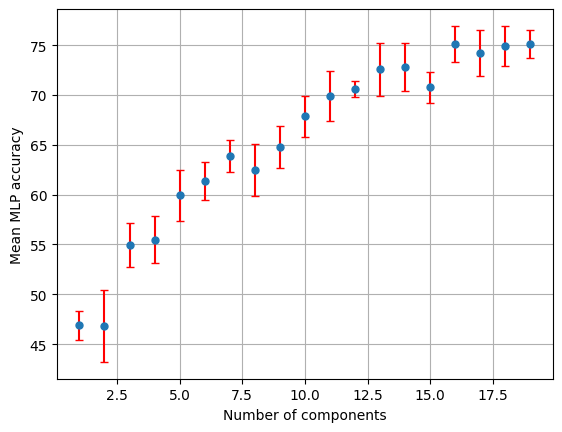

In [66]:
x = np.arange(MIN_K, MAX_K)
plt.errorbar(x, pca_accuracies_mean, yerr=pca_accuracies_std, fmt='o', markersize=5, ecolor='red', capsize=3, capthick=1)
plt.grid(True)
plt.xlabel("Number of principal components")
plt.ylabel("Mean MLP accuracy")
plt.show()

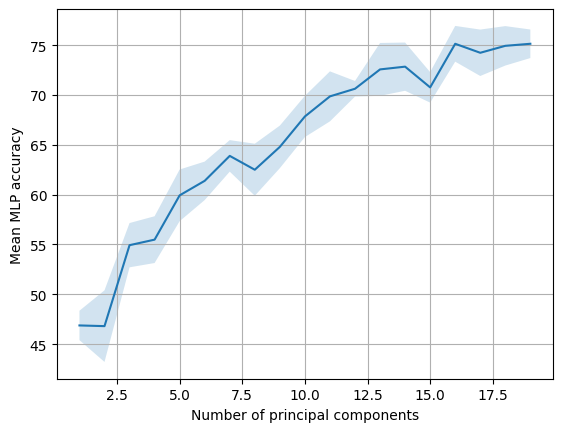

In [65]:
x = np.arange(MIN_K, MAX_K)
plt.plot(x, pca_accuracies_mean)
plt.fill_between(x, pca_accuracies_mean-pca_accuracies_std, pca_accuracies_mean+pca_accuracies_std, alpha=0.2)
plt.grid(True)
plt.xlabel("Number of principal components")
plt.ylabel("Mean MLP accuracy")
plt.show()

### 7. Experiments

#### 7.1 Train MLP on 2 blocks, test on remaining block
Objective: see MLP's robustness

In [55]:
K = 11

combinations = [
    [["block1", "block2"], ["block3"]],
    [["block1", "block3"], ["block2"]],
    [["block2", "block3"], ["block1"]],
    [["cylinder1", "cylinder2"], ["cylinder3"]],
    [["cylinder1", "cylinder3"], ["cylinder2"]],
    [["cylinder2", "cylinder3"], ["cylinder1"]],
    [["mustard_bottle1", "mustard_bottle2"], ["mustard_bottle3"]],
    [["mustard_bottle1", "mustard_bottle3"], ["mustard_bottle2"]],
    [["mustard_bottle2", "mustard_bottle3"], ["mustard_bottle1"]],
]

for combination in combinations:
    training_object_names = combination[0]
    testing_object_names = combination[1]

    mlp7a_X_train_ds, mlp7a_y_train_ds = prepare_cnn_dataset(training_object_names, object_features, pca_required=True, k=K)
    mlp7a_X_valid_ds, mlp7a_y_valid_ds = prepare_cnn_dataset(testing_object_names, object_features, pca_required=True, k=K)

    # Calculate the average accuracy across 5 training trials
    accuracies = []
    for _ in range(0, 5):
        mlp7a = MLP(input_size=mlp7a_X_train_ds.shape[1], hidden_size=64, output_size=1)
        mlp7a.train_mlp(epochs=500, X_train=mlp7a_X_train_ds, y_train=mlp7a_y_train_ds)
        accuracy = mlp7a.eval_mlp(X_test=mlp7a_X_valid_ds, y_test=mlp7a_y_valid_ds)
        accuracies.append(accuracy)

    print(np.mean(accuracies))

NameError: name 'prepare_cnn_dataset' is not defined

#### 7.2 Train MLP on randomly sampled subset of all objects
Objective: see influence of dataset size on accuracy;

In [ ]:
object_names = ["block1", "block2", "block3", "cylinder1", "cylinder2", "cylinder3", "mustard_bottle1", "mustard_bottle2", "mustard_bottle3"]

In [ ]:
object_features = np.concatenate((block_features, cylinder_features, bottle_features))

Random sampling with np.random.choice(replace=True), allowing repeated examples from the dataset to be sampled.

** Note: The following code block will take some time to run.

In [ ]:
accuracies = []
for _ in range(0, 5):
    trial_accuracies = []
    for input_size in range(100, 1500, 100):
        print(f"Input size {input_size}")
        mlp7b_final_ds, mlp7b_grasp_outcomes_ds = prepare_cnn_dataset(object_names, object_features, pca_required=False, k=11, sampling=True, N=input_size)
        X_final_complete_train, X_final_complete_test, y_final_complete_train, y_final_complete_test = train_test_split(mlp7b_final_ds, mlp7b_grasp_outcomes_ds, test_size=0.2)
        mlp7b = MLP(input_size=527, hidden_size=64, output_size=1)
        mlp7b.train_mlp(epochs=100, X_train=X_final_complete_train, y_train=y_final_complete_train)
        accuracy = mlp7b.eval_mlp(X_test=X_final_complete_test, y_test=y_final_complete_test, verbose=False)
        trial_accuracies.append(accuracy * 100)
    accuracies.append(trial_accuracies)

In [ ]:
accuracies = np.array(accuracies)
accuracies

In [ ]:
trial_accuracy_means = np.mean(accuracies, axis=0)
trial_accuracy_means

In [ ]:
plt.plot([i*100 for i in range(1, 15)], trial_accuracy_means)
plt.title('Impact of sample size of randomised dataset on MLP accuracy')
plt.ylabel('MLP Accuracy (%)')
plt.xlabel('Number of samples')
plt.show()